# FIT5149 S2 2020 
# Assessment 2: Residential Energy Appliance Classification

Student information

| Family Name | Given Name | Student ID | Student email |
| :------| :----------------- | :-------------- | :---------------- |
| Nguyen | Minh Thai |  |  |
| Nguyen | Ngoc Anh Duy | 31163009 | nngu0076@student.monash.edu |
| Le | Duy Tho |  |  |

Programming Language: R in Jupyter Notebook

R Libraries used:

| Name | Description |
| :------| :----------------- |
| psych, tidyr | Helpful built-in functions. |
| dplyr | A fast, consistent tool for working with data frame like objects, both in memory and out of memory. |
| ggplot2 | Plot chart |
| tsfeatures | Creates mew features for time-series data |
| dummies | For on hot encoding |

If any of below libraries showed warning: "could not find", please install that library by the following command `<install.packages("name of library")>`

In [38]:
# install.packages("psych")
# install.packages("tidyr")
# install.packages("dplyr")
# install.packages("ggplot2")
# install.packages("tsfeatures")
# install.packages("dummies")

In [116]:
library(psych)
library(dplyr)
library(tidyr)
library(tsfeatures)
library(dummies)
library(ggplot2)

## Table of Contents

1. [Introduction](#sec_1)
2. [Read data and Overview](#sec_2)
3. [Preprocessing](#sec_3)
4. [Exploratory Data Analysis](#sec_4)
5. [Methodology](#sec_5)

## 1. Introduction <a class="anchor" id="sec_1"></a>

In this assignment, we would study an issue related to household appliances - which is classification of the running electrical devices. This study benefits the deep research in energy production/consumption to reduce the greenhouse gas emissions, since Australia is a thermoelectric country.

The provided data for this assignment is time-series data and one record represents for one minute. The data is seperated into training data `"train_data_withlabels.csv"` and testing data `"test_data_nolabels"`.

The target is to classify whether the appliances are used or not. There are 5 appliances that we need to concern: 
* Air conditioner: ac
* Electric vehicle charger: ev
* Oven 
* Cloth washer: wash
* Dryer

To finish the assignment, we would divide it into several parts as in the content with appropriate discussion for each part.

## 2. Read data and Overview <a class="anchor" id="sec_2"></a>

Read the training data and testing data, then compute statistics to have an overview.

In [43]:
data <- read.csv("train_data_withlabels.csv")
data.test <- read.csv("test_data_nolabels.csv")

In [44]:
head(data)

X,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst
105541,2.245,0,0,0,0,0,0,Sun,0.987,0.987,6.215,3.074549,0.6788858,0.05290291,0.9940715
105542,2.259,0,0,0,0,0,0,Sun,0.014,0.014,6.215,3.172867,0.6674503,0.05482926,0.9941540
105543,2.269,0,0,0,0,0,0,Sun,0.010,0.010,6.215,3.270112,0.6477770,0.05699074,0.9942200
105544,2.268,0,0,0,0,0,0,Sun,-0.001,0.001,6.215,3.303763,0.6292270,0.05760593,0.9941497
105545,2.270,0,0,0,0,0,0,Sun,0.002,0.002,6.215,3.302744,0.6212951,0.08263997,0.9940406
105546,2.259,0,0,0,0,0,0,Sun,-0.011,0.011,6.215,3.298258,0.6269564,0.08978753,0.9939864


In [45]:
head(data.test)

X,load,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst
1,1.869,0,Mon,0.000,0.000,0,0,0,0,0
2,1.673,0,Mon,-0.196,0.196,0,0,0,0,0
3,1.660,0,Mon,-0.013,0.013,0,0,0,0,0
4,1.772,0,Mon,0.112,0.112,0,0,0,0,0
5,1.679,0,Mon,-0.093,0.093,0,0,0,0,0
6,1.775,0,Mon,0.096,0.096,0,0,0,0,0


There are 5 predicted variables which are 5 appliances: Air conditioner, Electric vehicle charger, Oven, Cloth washer, Dryer and some other variables including:
* X: index of time-series data
* load: electrical load
* hourofday: what time the data record was captured in a day
* dayofweek: which day the data record was captured in a week
* dif: difference between two sequential load data points
* absdif: absolute value of diff
* max: maximun load in that moment
* var: variance of load over a neighborhood time window of 30 minutes around each load data point
* entropy: the Shannon entropy that measures the "forecastability" of a time series data
* nonlinear: the nonlinearity coeffcient is used in Terasvirta's nonlinearity test
* hurst: the hurst is used as a measure of the long-term memory of a time series

where the features dif, absdif, var, entropy, nonlinear, hurst could be calculated from the time-series variables by performing advanced equations. However, we could use package `tsfresh` to compute or generate more features similarly.

We first check the missing values, duplicated values, etc by using summary() and describe() functions.

In [46]:
summary(data)

       X               load              ac               ev         
 Min.   :105541   Min.   : 0.298   Min.   :0.0000   Min.   :0.00000  
 1st Qu.:209971   1st Qu.: 0.807   1st Qu.:0.0000   1st Qu.:0.00000  
 Median :314401   Median : 1.279   Median :0.0000   Median :0.00000  
 Mean   :314401   Mean   : 2.185   Mean   :0.2423   Mean   :0.00559  
 3rd Qu.:418830   3rd Qu.: 3.358   3rd Qu.:0.0000   3rd Qu.:0.00000  
 Max.   :523260   Max.   :11.794   Max.   :1.0000   Max.   :1.00000  
                                                                     
      oven              wash             dryer          hourofday    
 Min.   :0.00000   Min.   :0.00000   Min.   :0.0000   Min.   : 0.00  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.0000   1st Qu.: 5.00  
 Median :0.00000   Median :0.00000   Median :0.0000   Median :11.00  
 Mean   :0.01426   Mean   :0.01904   Mean   :0.0325   Mean   :11.48  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.0000   3rd Qu.:17.00  
 Max.   :1.00000   M

In [47]:
summary(data.test)

       X               load          hourofday     dayofweek  
 Min.   :     1   Min.   : 0.417   Min.   : 0.00   Fri:15840  
 1st Qu.: 26386   1st Qu.: 0.986   1st Qu.: 6.00   Mon:14880  
 Median : 52771   Median : 1.393   Median :12.00   Sat:15840  
 Mean   : 52771   Mean   : 1.723   Mean   :11.52   Sun:14340  
 3rd Qu.: 79155   3rd Qu.: 1.759   3rd Qu.:18.00   Tue:14400  
 Max.   :105540   Max.   :12.174   Max.   :23.00   Thu:15840  
                                                   Wed:14400  
      dif                absdif            max              var          
 Min.   :-5.658000   Min.   :0.0000   Min.   : 0.000   Min.   :0.000000  
 1st Qu.:-0.007000   1st Qu.:0.0020   1st Qu.: 1.504   1st Qu.:0.004252  
 Median : 0.000000   Median :0.0070   Median : 2.462   Median :0.082662  
 Mean   :-0.000006   Mean   :0.1089   Mean   : 3.121   Mean   :0.884685  
 3rd Qu.: 0.006000   3rd Qu.:0.0300   3rd Qu.: 4.801   3rd Qu.:1.693558  
 Max.   : 6.816000   Max.   :6.8160   Max.   :12.174

In [48]:
describe(data)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X,1,417720,3.144005e+05,1.205855e+05,3.144005e+05,3.144005e+05,1.548279e+05,105541.000,5.232600e+05,4.177190e+05,-1.716869e-17,-1.20000862,1.865746e+02
load,2,417720,2.184664e+00,1.890565e+00,1.279000e+00,1.918025e+00,8.421168e-01,0.298,1.179400e+01,1.149600e+01,1.134783e+00,-0.07882485,2.925155e-03
ac,3,417720,2.422652e-01,4.284544e-01,0.000000e+00,1.778314e-01,0.000000e+00,0.000,1.000000e+00,1.000000e+00,1.203088e+00,-0.55258008,6.629213e-04
ev,4,417720,5.589869e-03,7.455626e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000,1.000000e+00,1.000000e+00,1.326271e+01,173.89984926,1.153563e-04
oven,5,417720,1.425835e-02,1.185542e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000,1.000000e+00,1.000000e+00,8.194407e+00,65.14845664,1.834316e-04
wash,6,417720,1.903907e-02,1.366625e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000,1.000000e+00,1.000000e+00,7.038652e+00,47.54274261,2.114495e-04
dryer,7,417720,3.250024e-02,1.773247e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000,1.000000e+00,1.000000e+00,5.272798e+00,25.80245821,2.743637e-04
hourofday,8,417720,1.148449e+01,6.920358e+00,1.100000e+01,1.148133e+01,8.895600e+00,0.000,2.300000e+01,2.300000e+01,3.070053e-03,-1.20380632,1.070745e-02
dayofweek*,9,417720,4.010198e+00,1.998935e+00,4.000000e+00,4.012748e+00,2.965200e+00,1.000,7.000000e+00,6.000000e+00,-2.375562e-03,-1.25116942,3.092830e-03
dif,10,417720,-7.038207e-07,5.309284e-01,-1.000000e-03,-2.249922e-03,1.482600e-02,-7.970,7.619000e+00,1.558900e+01,1.270821e+00,26.83443496,8.214731e-04


In [49]:
describe(data.test)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X,1,105540,5.277050e+04,3.046692e+04,5.277050e+04,5.277050e+04,3.911840e+04,1.000,1.055400e+05,1.055390e+05,0.000000000,-1.200034110,9.378211e+01
load,2,105540,1.722779e+00,1.221305e+00,1.393000e+00,1.436538e+00,5.885922e-01,0.417,1.217400e+01,1.175700e+01,2.286254574,5.289087518,3.759375e-03
hourofday,3,105540,1.152359e+01,6.935321e+00,1.200000e+01,1.152949e+01,8.895600e+00,0.000,2.300000e+01,2.300000e+01,-0.005049496,-1.207764007,2.134804e-02
dayofweek*,4,105540,3.963616e+00,2.007057e+00,4.000000e+00,3.954520e+00,2.965200e+00,1.000,7.000000e+00,6.000000e+00,0.016138019,-1.265894546,6.178045e-03
dif,5,105540,-5.789274e-06,4.024108e-01,0.000000e+00,-8.915814e-04,1.037820e-02,-5.658,6.816000e+00,1.247400e+01,1.127059791,36.224181291,1.238686e-03
absdif,6,105540,1.089044e-01,3.873941e-01,7.000000e-03,1.782524e-02,8.895600e-03,0.000,6.816000e+00,6.816000e+00,5.562806231,35.933129663,1.192462e-03
max,7,105540,3.121496e+00,1.963975e+00,2.462000e+00,2.927757e+00,1.997062e+00,0.000,1.217400e+01,1.217400e+01,0.808323120,-0.005874391,6.045433e-03
var,8,105540,8.846850e-01,1.329626e+00,8.266229e-02,6.164955e-01,1.212804e-01,0.000,9.176924e+00,9.176924e+00,1.611892775,2.308372874,4.092803e-03
entropy,9,105540,7.223980e-01,1.006660e-01,6.923847e-01,7.119426e-01,8.264481e-02,0.000,9.998878e-01,9.998878e-01,0.759173123,0.623655386,3.098663e-04
nonlinear,10,105540,1.528213e+00,2.804662e+00,6.837506e-01,9.479095e-01,7.796508e-01,0.000,6.558679e+01,6.558679e+01,5.578004861,47.176136270,8.633204e-03


Obviously, there is no potential error in both training and testing data.

The main variable - __load__ - has the mean higher than 1.7 and standard deviation higher than 1.2, assume that if there are no appliances are used, the load is near to 0, we could conclude that __there is a clear change in the load when one appliance is used.__ The skew and kurtosis both support this inference.

The range of load is high, it means that there could be more than one appliance are used in a specific moment.

dif, absdif and max are similar to the load, which signal more clearly when an appliance is used.

Because the data was recorded in a sequential period, hourofday and dayofweek are balanced their values.

The others are calculated by the load so Their statistical factors differ according to the aspect they describe.

## 3. Preprocessing<a class="anchor" id="sec_3"></a>

We need to find the duration of data for both training and testing

In [52]:
cat("Training data was observed in approximately", round(nrow(data)/60/24), "days \n")
cat("Testing data was observed in approximately", round(nrow(data.test)/60/24), "days")

Training data was observed in approximately 290 days 
Testing data was observed in approximately 73 days

__Starting from here, we would explore the training data only to preserve objectivity. Then we will perform the same preprocessing step for the testing data__

### 3.1 Data load

We plot partial the load using line chart

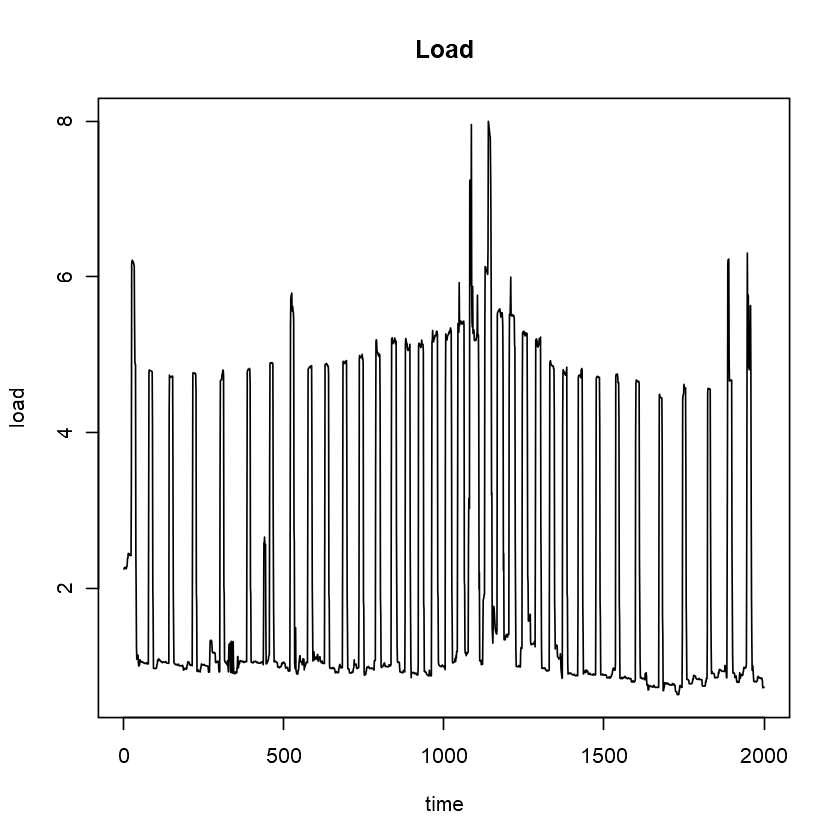

In [7]:
plot(data$load[1:2000], type="l", col="black", xlab="time", ylab="load", main="Load")

According to the chart:
* Our onjecture about the load is correct, there is a clear change in the load when one appliance is used
* While using, the appliance would use different amounts of electricity. Therefore, the load showed the fluctuation at high level
* The number of times each device is used is different
* Usage time is also different

__How many times does each appliance run?__

In [8]:
# define variables
ac <- 0
ev <- 0
oven <- 0
wash <- 0
dryer <- 0

# go through the data and update if appliances were activated
for (i in 2:nrow(data)) {
    if (data$ac[i] == 1 & data$ac[i-1] == 0) {
        ac <- ac + 1
    }
    if (data$ev[i] == 1 & data$ev[i-1] == 0) {
        ev <- ev + 1
    }
    if (data$oven[i] == 1 & data$oven[i-1] == 0) {
        oven <- oven + 1
    }
    if (data$wash[i] == 1 & data$wash[i-1] == 0) {
        wash <- wash + 1
    }
    if (data$dryer[i] == 1 & data$dryer[i-1] == 0) {
        dryer <- dryer + 1
    }
}

# print
cat("Air conditioner (ac) was used", ac, "times \n")
cat("Electric Vehicle Charger (ev) was used", ev, "times \n")
cat("Oven was used", oven, "times \n")
cat("Cloth Washer (wash) was used", wash, "times \n")
cat("Dryer was used", dryer, "times")

Air conditioner (ac) was used 4799 times 
Electric Vehicle Charger (ev) was used 34 times 
Oven was used 1076 times 
Cloth Washer (wash) was used 1249 times 
Dryer was used 170 times

__How many minutes does each appliance run on average per usage?__

In [9]:
# get sum of minutes each appliance run and divided by times they were activated
ac.average.running <- round(data %>% filter(ac == 1) %>% nrow() / ac, 2)
ev.average.running <- round(data %>% filter(ev == 1) %>% nrow() / ev, 2)
oven.average.running <- round(data %>% filter(oven == 1) %>% nrow() / oven, 2)
wash.average.running <- round(data %>% filter(wash == 1) %>% nrow() / wash, 2)
dryer.average.running <- round(data %>% filter(dryer == 1) %>% nrow() / dryer, 2)

#print
cat("Air conditioner (ac) was used on average", ac.average.running, "minutes per running \n")
cat("Electric Vehicle Charger (ev) was used on average", ev.average.running, "minutes per running \n")
cat("Oven was used on average", oven.average.running, "minutes per running \n")
cat("Cloth Washer (wash) was used on average", wash.average.running, "minutes per running \n")
cat("Dryer was used on average", dryer.average.running, "minutes per running")

Air conditioner (ac) was used on average 21.09 minutes per running 
Electric Vehicle Charger (ev) was used on average 68.68 minutes per running 
Oven was used on average 5.54 minutes per running 
Cloth Washer (wash) was used on average 6.37 minutes per running 
Dryer was used on average 79.86 minutes per running

__How much electricity does each appliance use per minute?__

In [66]:
#get sum of load each appliance and divided by sum of minutes they run
#1.3 is the approximately minimun when no devices runs
ac.used <- data %>% filter(ac == 1) %>% select("load") %>% sum() / data %>% filter(ac == 1) %>% nrow() - 1.3
ev.used <- data %>% filter(ev == 1) %>% select("load") %>% sum() / data %>% filter(ev == 1) %>% nrow() - 1.3
oven.used <- data %>% filter(oven == 1) %>% select("load") %>% sum() / data %>% filter(oven == 1) %>% nrow() - 1.3
wash.used <- data %>% filter(wash == 1) %>% select("load") %>% sum() / data %>% filter(wash == 1) %>% nrow() - 1.3
dryer.used <- data %>% filter(dryer == 1) %>% select("load") %>% sum() / data %>% filter(dryer == 1) %>% nrow() - 1.3

#print
cat("The approximately electricity of Air conditioner (ac) is ", round(ac.used,2), "\n")
cat("The approximately electricity of Electric Vehicle Charger (ev) is ", round(ev.used,2), "\n")
cat("The approximately electricity of Oven is ", round(oven.used,2), "\n")
cat("The approximately electricity of Cloth Washer (wash) is ", round(wash.used,2), "\n")
cat("The approximately electricity of Dryer is ", round(dryer.used,2), "\n")

The approximately electricity of Air conditioner (ac) is  3.92 
The approximately electricity of Electric Vehicle Charger (ev) is  4.23 
The approximately electricity of Oven is  4.01 
The approximately electricity of Cloth Washer (wash) is  1.4 
The approximately electricity of Dryer is  1.46 


__Plot the above results__

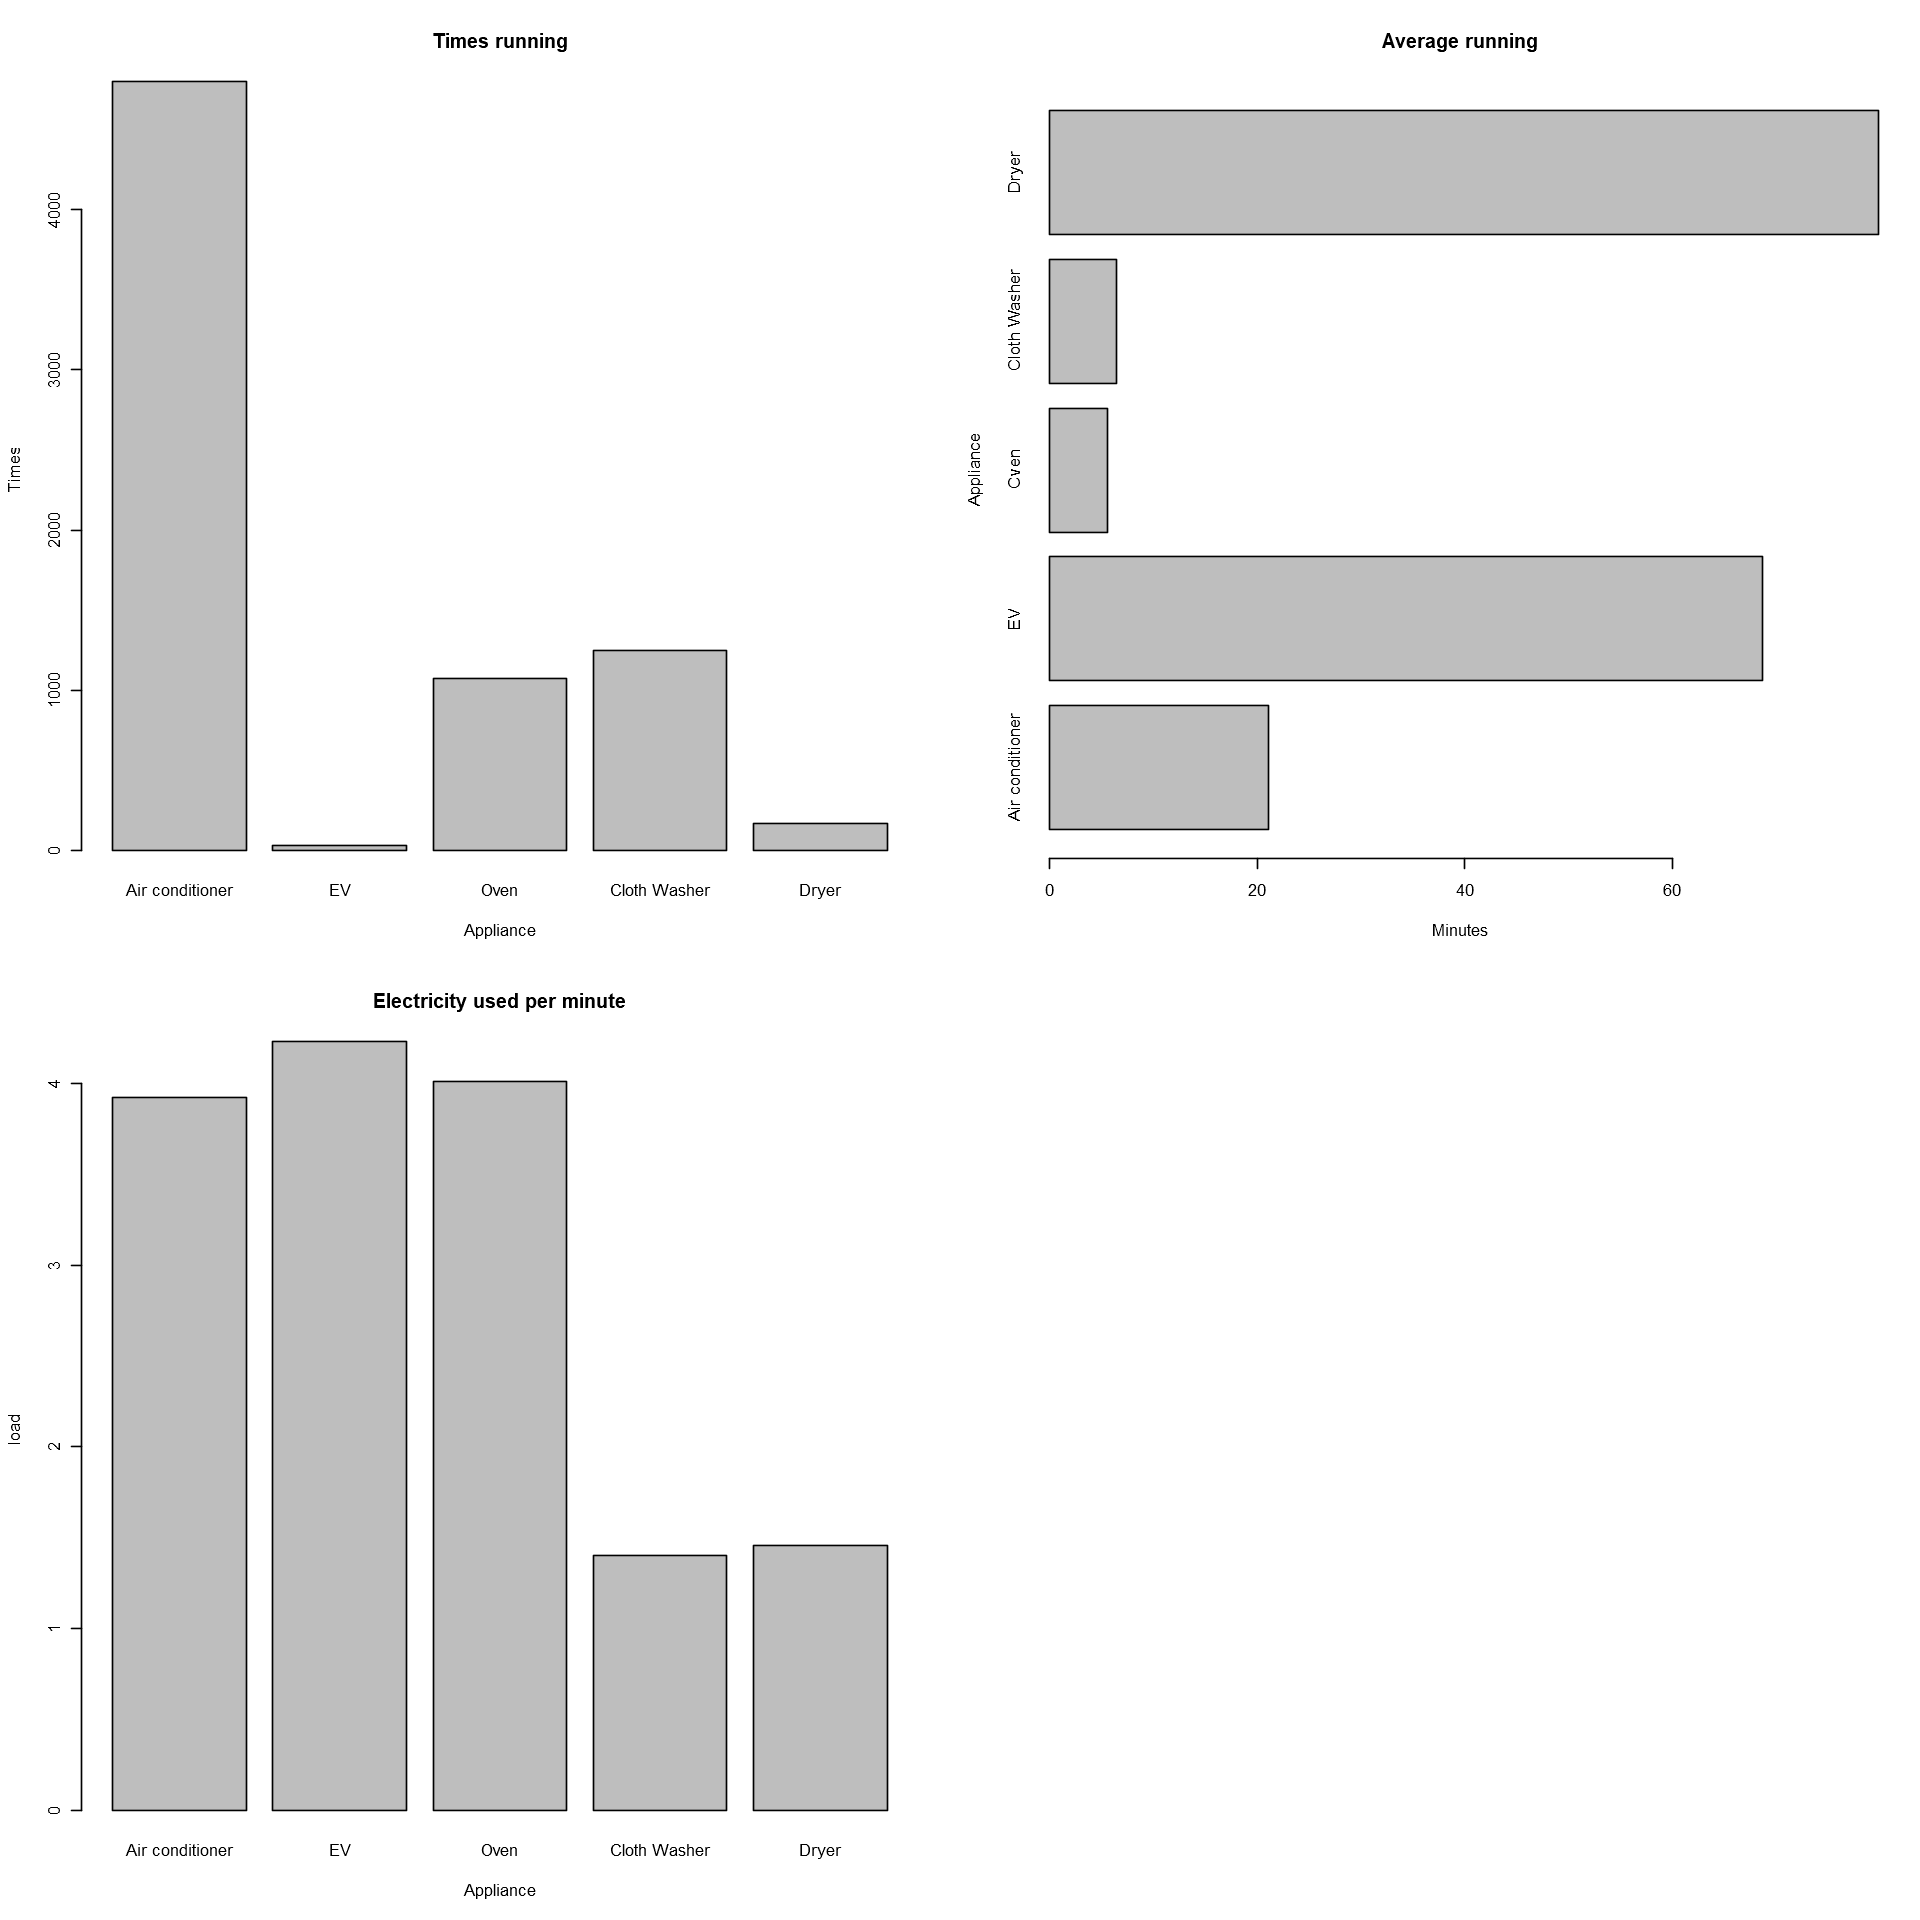

In [70]:
par(mfrow = c(2,2))
options(repr.plot.width=16, repr.plot.height=16)

barplot(c(ac, ev, oven, wash, dryer), main="Times running", xlab = "Appliance", ylab = "Times",
        names.arg = c("Air conditioner", "EV", "Oven", "Cloth Washer", "Dryer"))
barplot(c(ac.average.running, ev.average.running, oven.average.running, wash.average.running, dryer.average.running), 
        main="Average running", xlab = "Minutes", ylab = "Appliance", horiz=TRUE,
        names.arg = c("Air conditioner", "EV", "Oven", "Cloth Washer", "Dryer"))
barplot(c(ac.used, ev.used, oven.used, wash.used, dryer.used), main="Electricity used per minute", xlab = "Appliance", ylab = "load",
        names.arg = c("Air conditioner", "EV", "Oven", "Cloth Washer", "Dryer"))

__Something we realize:__

The absdif is important as it immediately classify two groups of devices, if the electricity used is more different, absdif could be used for classification.

The dif showed whether the appliance is turned off or not.

As in this early stage, our opinion is that we need to perform more new variables to have better model. We would calculate new features using `tsfresh` with the window of 36 minutes because the mean of running minutes of all appliances is 36.

In [71]:
mean(c(ac.average.running, ev.average.running, oven.average.running, wash.average.running, dryer.average.running))

[1] 36.308

### 3.2 New features

We used `tsfresh` package to compute 8 new features which is the default calculated feature of `tsfresh`:

__Mean__

Mean of load in every 36 minutes $\frac{1}{36}\sum_{i=0}^{36} load_i$

__Variance__

Variance of load in every 36 minutes

__Entropy__

The spectral entropy is the Shannon entropy $$-\int_{-\pi}^{\pi}\hat{f}(\lambda) \log \hat{f} (\lambda)d \lambda$$ where $\hat{f} (\lambda)$ is an estimate of the spectral density of the data. This measures the “forecastability” of a time series, where low values indicate a high signal-to-noise ratio, and large values occur when a series is difficult to forecast.

__Nonlinearity__

The nonlinearity coefficient is computed using a modification of the statistic used in Teräsvirta’s nonlinearity test. Teräsvirta’s test uses a statistic $X^2 = T \log (\frac{SSE_1}{SSE_0})$ where $SSE_1$ and $SSE_0$ are the sum of squared residuals from a nonlinear and linear autoregression respectively. This is non-ergodic, so instead, we define it as $\frac{10X^2}{T}$ which will converge to a value indicating the extent of nonlinearity as $T \rightarrow \infty$. This takes large values when the series is nonlinear, and values around 0 when the series is linear.

__Hurst__

We use a measure of the long-term memory of a time series (hurst), computed as 0.5 plus the maximum likelihood estimate of the fractional differencing order d given by Haslett & Raftery (1989). We add 0.5 to make it consistent with the Hurst coefficient. Note that the fractal dimension can be estimated as $D=2−hurst$

__Crossing point__

Crossing points are defined as the number of times a time series crosses the median line.

__Lumpiness and Stability__

Stability and lumpiness are two time series features based on tiled (non-overlapping) windows. Means or variances are produced for all tiled windows. Then stability is the variance of the means, while lumpiness is the variance of the variance

In [72]:
# add new columns
data$mean <- 0
data$var.new <- 0
data$entropy.new <- 0
data$nonlinear.new <- 0
data$hurst.new <- 0
data$crossingpoints <- 0
data$stability <- 0
data$lumpiness <- 0

#print
head(data)

X,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,...,nonlinear,hurst,mean,var.new,entropy.new,nonlinear.new,hurst.new,crossingpoints,stability,lumpiness
105541,2.245,0,0,0,0,0,0,Sun,0.987,...,0.05290291,0.9940715,0,0,0,0,0,0,0,0
105542,2.259,0,0,0,0,0,0,Sun,0.014,...,0.05482926,0.9941540,0,0,0,0,0,0,0,0
105543,2.269,0,0,0,0,0,0,Sun,0.010,...,0.05699074,0.9942200,0,0,0,0,0,0,0,0
105544,2.268,0,0,0,0,0,0,Sun,-0.001,...,0.05760593,0.9941497,0,0,0,0,0,0,0,0
105545,2.270,0,0,0,0,0,0,Sun,0.002,...,0.08263997,0.9940406,0,0,0,0,0,0,0,0
105546,2.259,0,0,0,0,0,0,Sun,-0.011,...,0.08978753,0.9939864,0,0,0,0,0,0,0,0


In [17]:
#adding new features
for (i in 36:nrow(data)) {
    temp1 <- tsfeatures(data$load[(i-36):i], c("mean", "var"), scale=FALSE, na.rm=TRUE)
    temp2 <- tsfeatures(data$load[(i-36):i], c("entropy", "nonlinearity", "hurst", "crossing_points", "stability", "lumpiness"))
    data$mean[i] <- temp1[[1]]
    data$var.new[i] <- temp1[[2]]
    data$entropy.new[i] <- temp2[[1]]
    data$nonlinear.new[i] <- temp2[[2]]
    data$hurst.new[i] <- temp2[[3]]
    data$crossingpoints[i] <- temp2[[4]]
    data$stability[i] <- temp2[[5]]
    data$lumpiness[i] <- temp2[[6]]
}

In [18]:
#print
data[30:40,]

,X,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,...,nonlinear,hurst,mean,var.new,entropy.new,nonlinear.new,hurst.new,crossingpoints,stability,lumpiness
30,105570,6.178,1,0,0,0,0,0,Sun,-0.021,...,0.3299405,0.9936407,0.000000,0.000000,0.0000000,0.000000,0.0000000,0,0.0000000,0.00000000
31,105571,6.183,1,0,0,0,0,0,Sun,0.005,...,0.3656885,0.9938213,0.000000,0.000000,0.0000000,0.000000,0.0000000,0,0.0000000,0.00000000
32,105572,6.155,1,0,0,0,0,0,Sun,-0.028,...,0.3701465,0.9938042,0.000000,0.000000,0.0000000,0.000000,0.0000000,0,0.0000000,0.00000000
33,105573,6.143,1,0,0,0,0,0,Sun,-0.012,...,0.3741793,0.9938262,0.000000,0.000000,0.0000000,0.000000,0.0000000,0,0.0000000,0.00000000
34,105574,5.419,1,0,0,0,0,0,Sun,-0.724,...,0.3814064,0.9938472,0.000000,0.000000,0.0000000,0.000000,0.0000000,0,0.0000000,0.00000000
35,105575,4.915,1,0,0,0,0,0,Sun,-0.504,...,0.3886660,0.9938672,0.000000,0.000000,0.0000000,0.000000,0.0000000,0,0.0000000,0.00000000
36,105576,4.881,1,0,0,0,0,0,Sun,-0.034,...,0.3985327,0.9938860,3.562111,2.941422,0.4568797,8.293985,0.9892740,5,0.6782984,0.44787452
37,105577,4.872,1,0,0,0,0,0,Sun,-0.009,...,0.4090332,0.9939035,3.597514,2.906089,0.4659622,8.228762,0.9895896,3,0.6865454,0.45883147
38,105578,2.491,1,0,0,0,0,0,Sun,-2.381,...,0.4189994,0.9939198,3.604162,2.889240,0.5632488,5.307209,0.9860191,5,0.9124192,0.32647371
39,105579,1.965,0,0,0,0,0,0,Sun,-0.526,...,0.4279781,0.9939354,3.596216,2.913547,0.5784315,4.423800,0.9858433,6,1.1549479,0.15428940


We have done added more features into data.

### 3.3 One hot encoding for day of week

In [28]:
data <- dummy.data.frame(data, names = c("dayofweek"), sep="_")

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"

In [29]:
head(data)

X,load,ac,ev,oven,wash,dryer,hourofday,dayofweek_Fri,dayofweek_Mon,...,nonlinear,hurst,mean,var.new,entropy.new,nonlinear.new,hurst.new,crossingpoints,stability,lumpiness
105541,2.245,0,0,0,0,0,0,0,0,...,0.05290291,0.9940715,0,0,0,0,0,0,0,0
105542,2.259,0,0,0,0,0,0,0,0,...,0.05482926,0.9941540,0,0,0,0,0,0,0,0
105543,2.269,0,0,0,0,0,0,0,0,...,0.05699074,0.9942200,0,0,0,0,0,0,0,0
105544,2.268,0,0,0,0,0,0,0,0,...,0.05760593,0.9941497,0,0,0,0,0,0,0,0
105545,2.270,0,0,0,0,0,0,0,0,...,0.08263997,0.9940406,0,0,0,0,0,0,0,0
105546,2.259,0,0,0,0,0,0,0,0,...,0.08978753,0.9939864,0,0,0,0,0,0,0,0


Because calcultion of new features and dayofweek required time (nearly 1 hour), so after running, store the data in case we make mistakes. The below code is always commented out.

In [87]:
# write.csv(data, "data.csv")
# data <- read.csv("data.csv")  %>% select(c(-1)) # drop the index column

## 4. Exploratory Data Analysis<a class="anchor" id="sec_4"></a>

The data we have after preprocessing step has 30 features whose name as below and 417720 data records.

In [88]:
colnames(data)
dim(data)

[1] "X"              "load"           "ac"             "ev"            
 [5] "oven"           "wash"           "dryer"          "hourofday"     
 [9] "dayofweek_Fri"  "dayofweek_Mon"  "dayofweek_Sat"  "dayofweek_Sun" 
[13] "dayofweek_Tue"  "dayofweek_Thu"  "dayofweek_Wed"  "dif"           
[17] "absdif"         "max"            "var"            "entropy"       
[21] "nonlinear"      "hurst"          "mean"           "var.new"       
[25] "entropy.new"    "nonlinear.new"  "hurst.new"      "crossingpoints"
[29] "stability"      "lumpiness"

[1] 417720     30

Our data

In [89]:
data <- data %>% select(c(-1))
head(data)

load,ac,ev,oven,wash,dryer,hourofday,dayofweek_Fri,dayofweek_Mon,dayofweek_Sat,...,nonlinear,hurst,mean,var.new,entropy.new,nonlinear.new,hurst.new,crossingpoints,stability,lumpiness
2.245,0,0,0,0,0,0,0,0,0,...,0.05290291,0.9940715,0,0,0,0,0,0,0,0
2.259,0,0,0,0,0,0,0,0,0,...,0.05482926,0.9941540,0,0,0,0,0,0,0,0
2.269,0,0,0,0,0,0,0,0,0,...,0.05699074,0.9942200,0,0,0,0,0,0,0,0
2.268,0,0,0,0,0,0,0,0,0,...,0.05760593,0.9941497,0,0,0,0,0,0,0,0
2.270,0,0,0,0,0,0,0,0,0,...,0.08263997,0.9940406,0,0,0,0,0,0,0,0
2.259,0,0,0,0,0,0,0,0,0,...,0.08978753,0.9939864,0,0,0,0,0,0,0,0


__In order to reduce the memory to store the data - since this is a part of big data - we not only to find the smallest subset of features, but it also works for 5 classifications__

### 4.1 Use correlation matrix to get the significant features

Because using pair() required long time to compute, we only use a simple function to see the correlation of the data

In [90]:
cor(data)

,load,ac,ev,oven,wash,dryer,hourofday,dayofweek_Fri,dayofweek_Mon,dayofweek_Sat,...,nonlinear,hurst,mean,var.new,entropy.new,nonlinear.new,hurst.new,crossingpoints,stability,lumpiness
load,1.0000000000,0.908138189,0.1326114177,0.198625965,0.038059818,0.0553991249,0.2667702417,-1.392690e-02,-0.0132354164,2.414914e-02,...,-0.113487956,0.0244198911,0.6203746595,0.4345927829,-0.0373651226,-0.004502803,0.0091782895,0.057960381,-0.0567889177,-0.0890737917
ac,0.9081381885,1.000000000,-0.0023748567,0.036528731,0.001360042,0.0059240522,0.1513638555,-3.392851e-03,-0.0173648712,1.568466e-02,...,-0.100161803,0.1178483929,0.4907614249,0.4624388781,-0.1102584785,0.029672677,0.0937911413,-0.043296222,-0.0064480939,-0.0981533174
ev,0.1326114177,-0.002374857,1.0000000000,-0.007392142,-0.010445159,-0.0001608067,0.0531388114,-9.237445e-03,0.0153714402,1.627238e-02,...,0.015643522,-0.0155112977,0.1681051974,0.0050151783,0.0052099176,0.003393152,-0.0109947453,0.001127794,-0.0119452467,0.0220641839
oven,0.1986259648,0.036528731,-0.0073921417,1.000000000,0.010727688,0.0166746063,0.0858370175,4.797517e-03,-0.0065012100,2.210478e-03,...,-0.031538227,-0.0549684405,0.1539281968,0.1022555255,0.0476490735,-0.030408225,-0.0504978613,0.091243428,-0.0498128477,-0.0296228362
wash,0.0380598183,0.001360042,-0.0104451586,0.010727688,1.000000000,0.0650533949,0.0449651073,-3.105718e-02,0.0167778570,-8.798864e-03,...,-0.022147994,-0.0011205496,0.0402970804,-0.0117098972,0.0148093561,-0.026285875,-0.0051282810,0.034784636,-0.0121691605,-0.0100728903
dryer,0.0553991249,0.005924052,-0.0001608067,0.016674606,0.065053395,1.0000000000,0.0705956220,-3.863649e-02,0.0306906294,1.207215e-02,...,-0.027731104,-0.0246036771,0.0713693252,-0.0089520864,0.0299970183,-0.036489779,-0.0572415988,0.083406264,-0.0176188697,-0.0123189358
hourofday,0.2667702417,0.151363856,0.0531388114,0.085837017,0.044965107,0.0705956220,1.0000000000,-3.381250e-03,-0.0009443430,-2.938508e-03,...,-0.090148814,-0.0904056338,0.3739681555,0.1139818892,0.0594012549,-0.103930566,-0.1021005994,0.133356578,-0.0356858414,-0.0106264803
dayofweek_Fri,-0.0139269047,-0.003392851,-0.0092374450,0.004797517,-0.031057179,-0.0386364920,-0.0033812499,1.000000e+00,-0.1671821234,-1.617854e-01,...,0.007403261,0.0101796695,-0.0190484055,-0.0010042775,-0.0053098349,0.001212774,0.0104831879,-0.010345711,0.0034024497,-0.0042407563
dayofweek_Mon,-0.0132354164,-0.017364871,0.0153714402,-0.006501210,0.016777857,0.0306906294,-0.0009443430,-1.671821e-01,1.0000000000,-1.668819e-01,...,0.006108659,0.0009699731,-0.0180659391,-0.0200980227,-0.0009274071,-0.003609159,-0.0017321335,0.002622177,-0.0012631531,0.0007580537
dayofweek_Sat,0.0241491355,0.015684660,0.0162723833,0.002210478,-0.008798864,0.0120721544,-0.0029385077,-1.617854e-01,-0.1668818828,1.000000e+00,...,0.001584503,0.0022862321,0.0327160246,0.0188812974,-0.0110226552,-0.001154305,0.0059153618,-0.008215142,0.0051891553,-0.0003044291


We could divide the features into groups:
* load: as mentioned in preprocessing step
* hourofday: from 0 to 23
* dayofweek: we have done the one hot encoding
* statistical features

By the correlation matrix:
* the day is not significant since the absolute all of values are less than 0.05
* the load is partial significant since with Air conditioner, the value is 0.9 while only 0.04 for Cloth Washer
* the hourofday showed low significant
* most of the statistical features showed remarkable significant except stability and lumpiness

### 4.2 Day of week

There are 7 days per week and it is a prior opinion that people usually do household at weekend such as washing, dryer. The others including Air conditioner, Electric Vehicle Charger, Oven could be used at any days.

We would like to plot to check this opinion

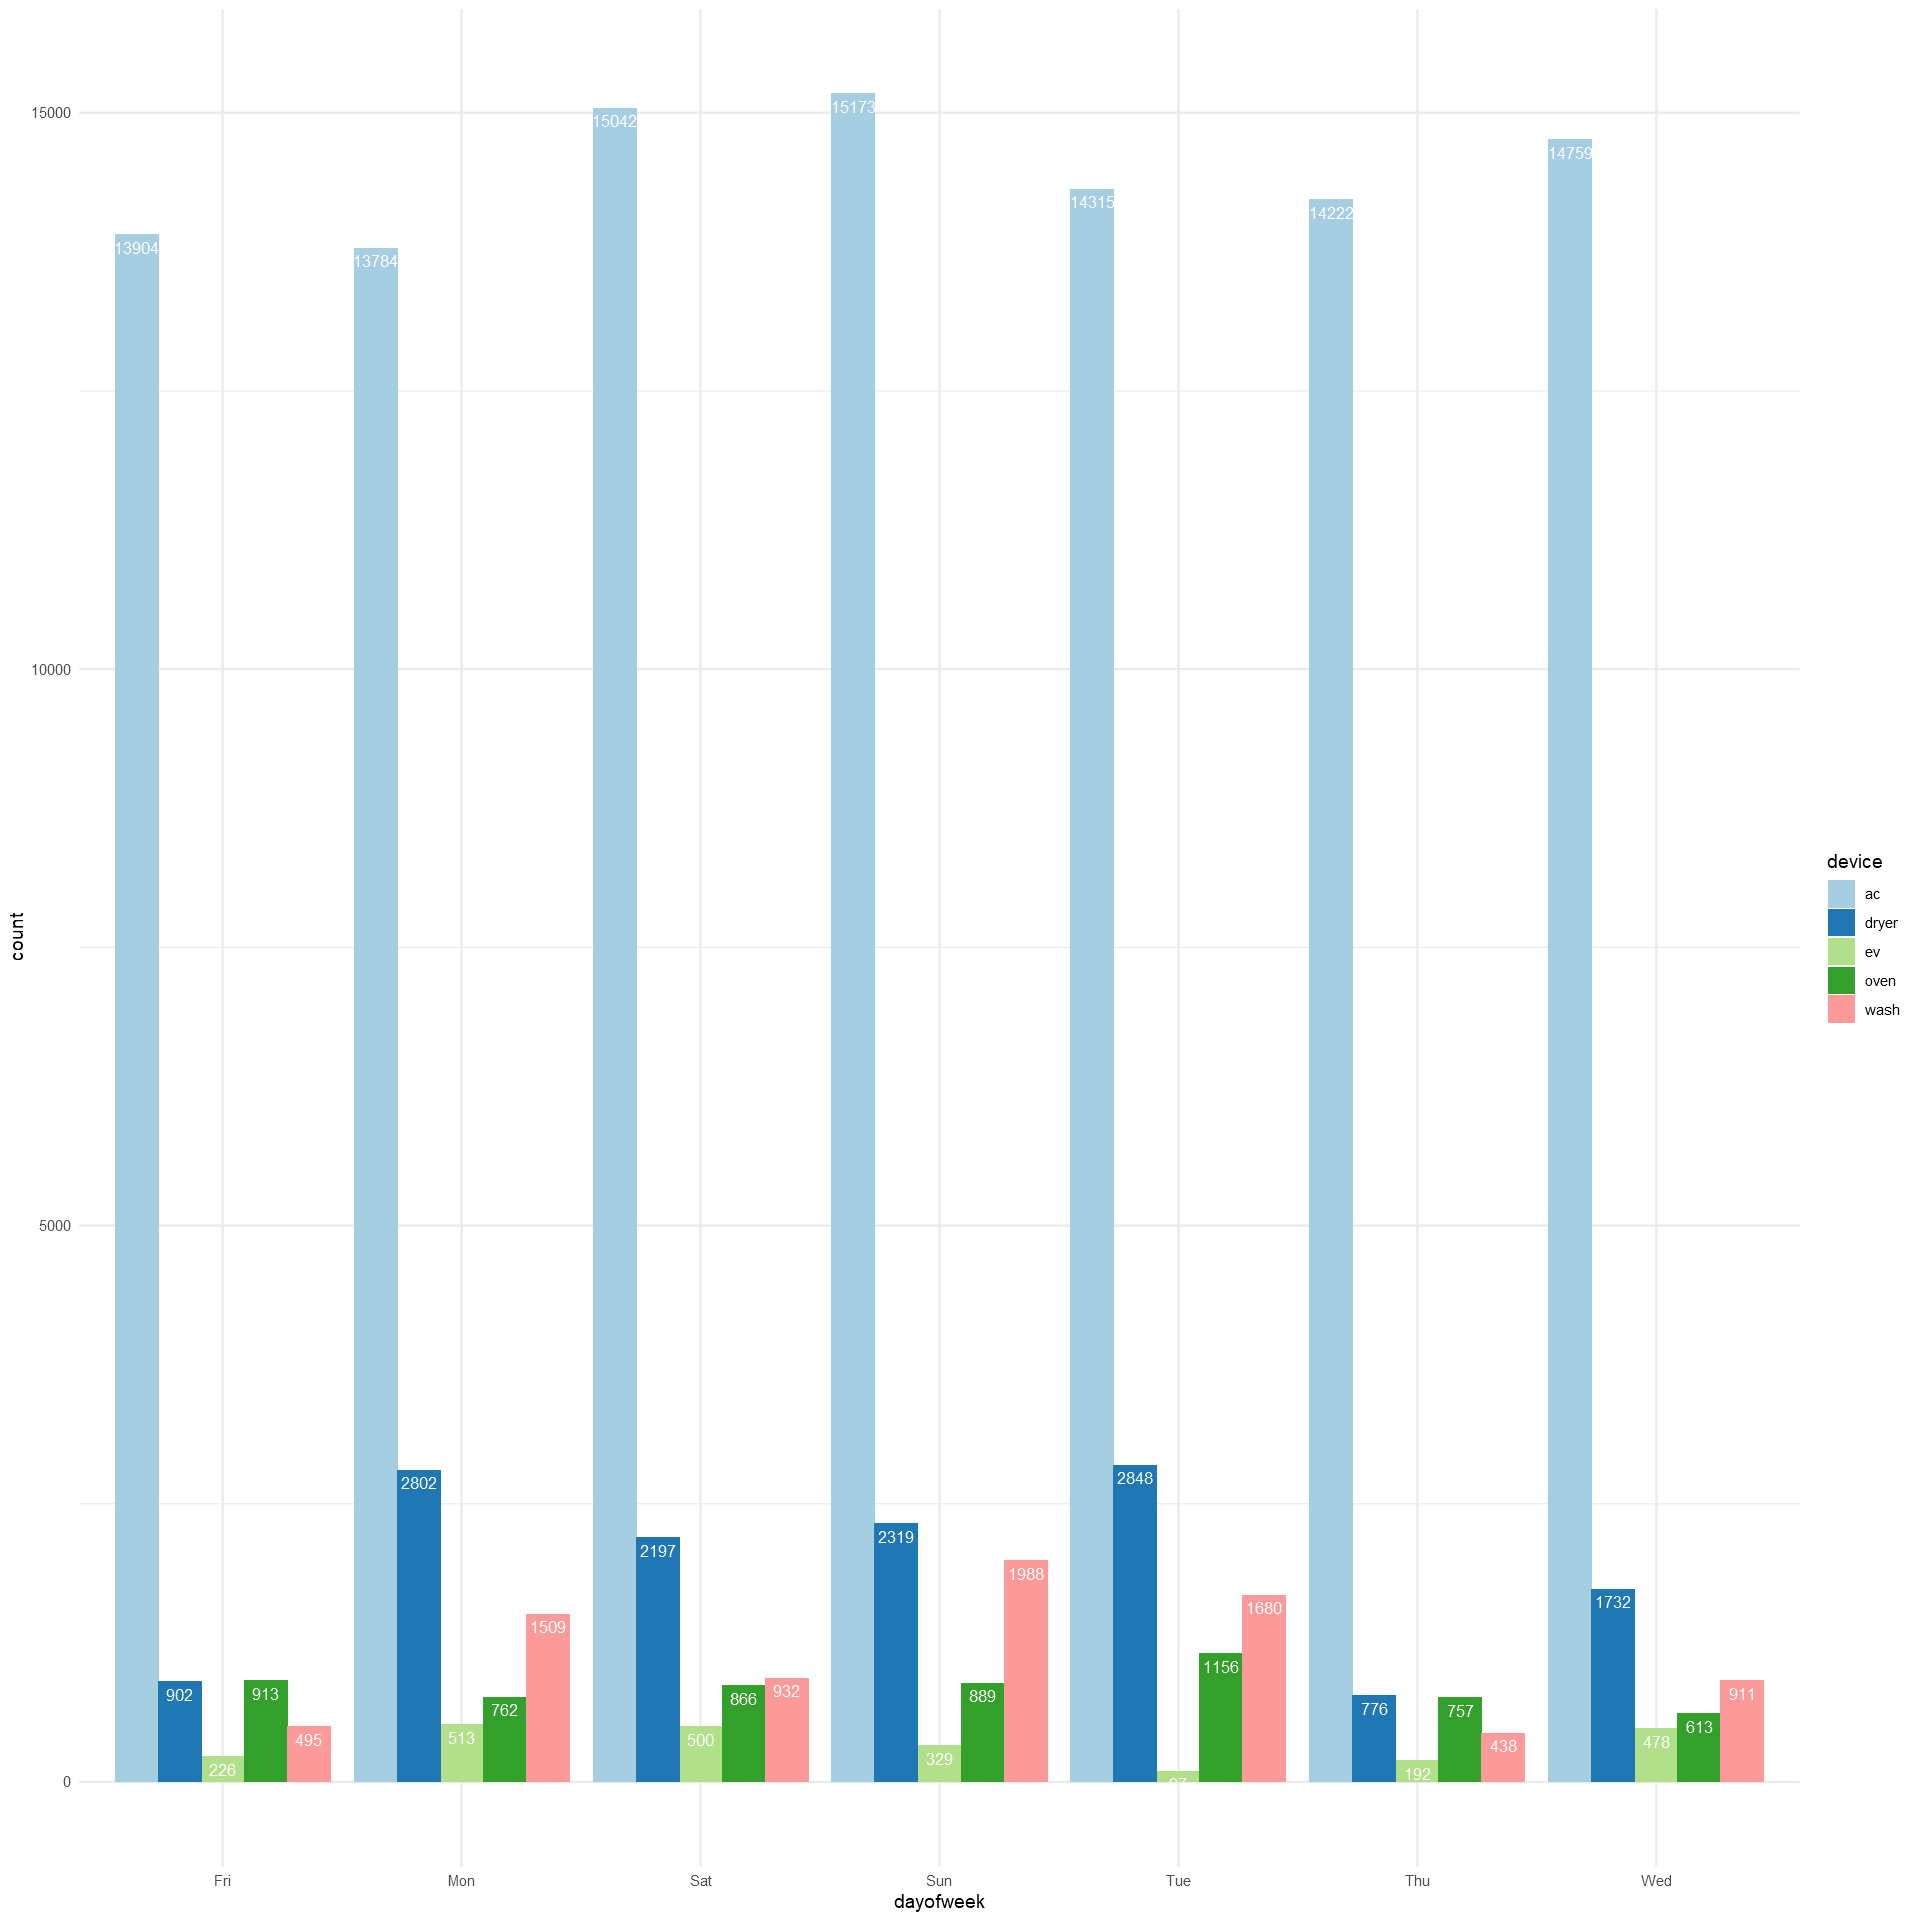

In [125]:
# read the original data for converting into long format easily
# select necessary columns and aggreate
# convert into long format
temp <- read.csv("train_data_withlabels.csv") %>% select(c(3:7,9))
temp <- aggregate(. ~ dayofweek, temp, sum)
temp <- temp %>% pivot_longer(!dayofweek, names_to = "device", values_to = "count")

#plot
ggplot(data=temp, aes(x=dayofweek, y=count, fill=device)) +
  geom_bar(stat="identity", position=position_dodge())+
  geom_text(aes(label=count), vjust=1.6, color="white",
            position = position_dodge(0.9), size=3.5)+
  scale_fill_brewer(palette="Paired")+
  theme_minimal()

As the plot, the prior knowlegde is rejected. It seems like people prefer using appliance immediately as they need whether than following a rule.

### 4.3 Hour of day

Since people need to go to work or study, they only do some household work when they have time.

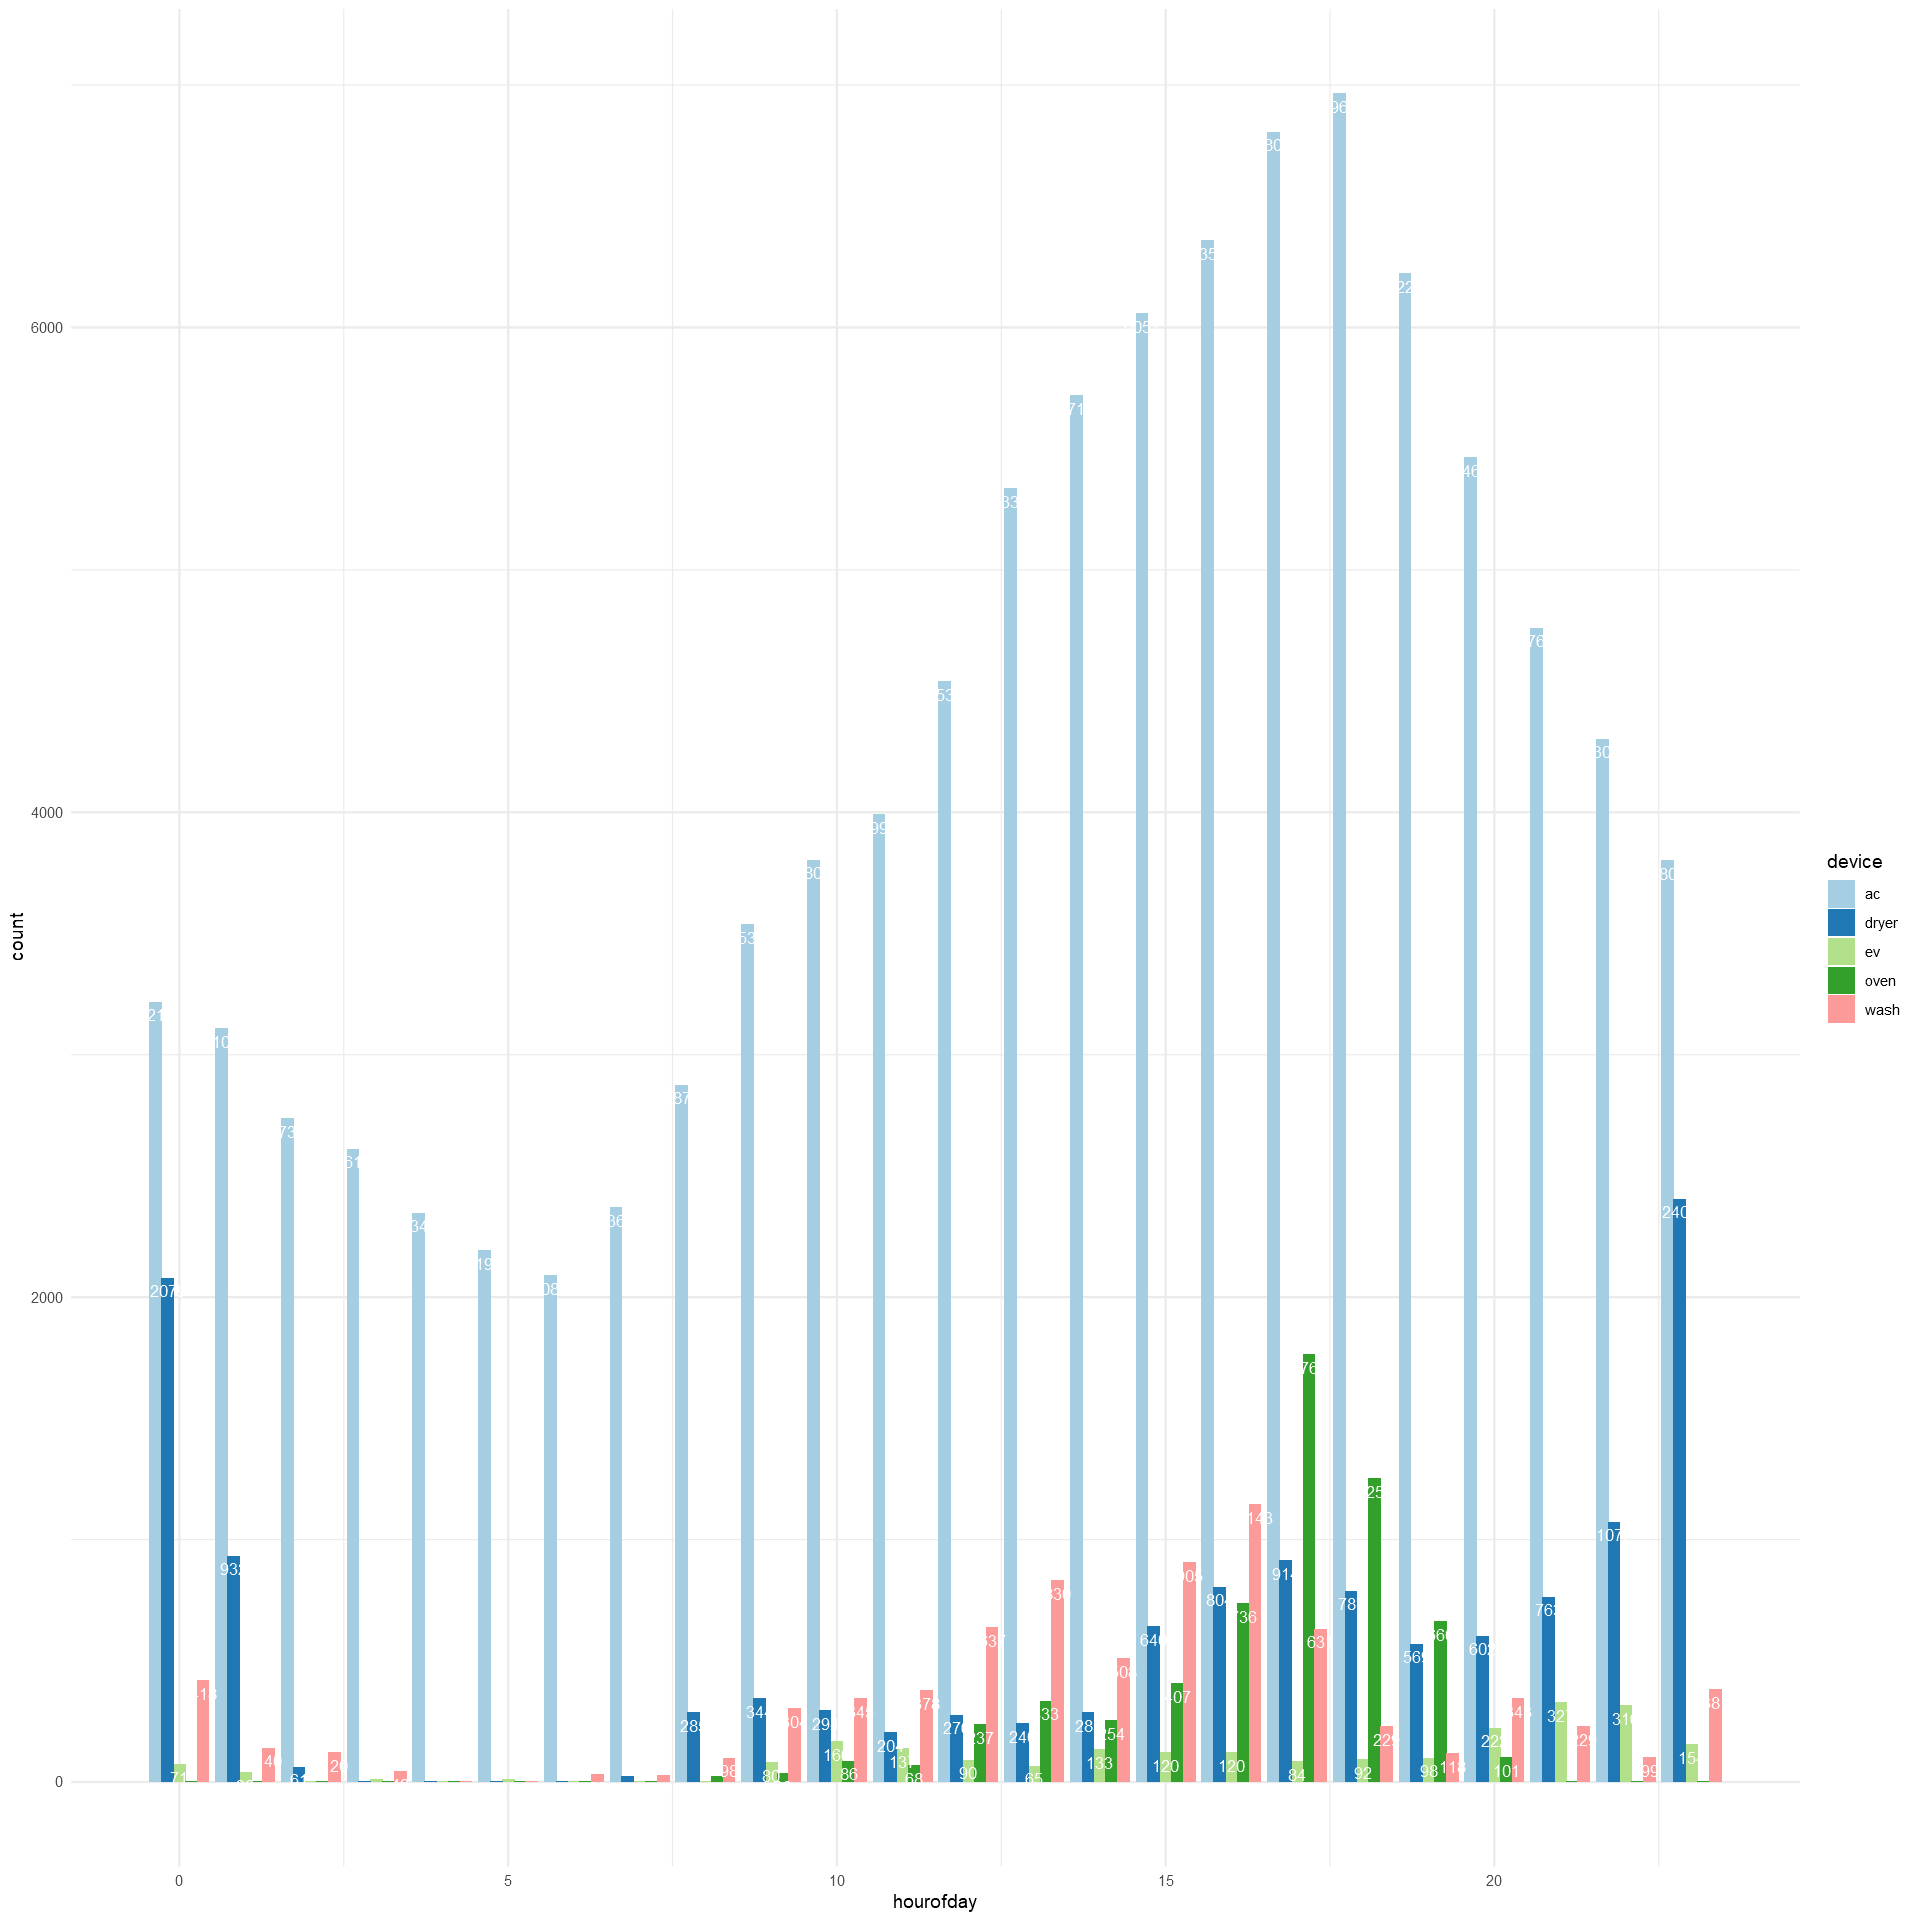

In [126]:
# read the original data for converting into long format easily
# select necessary columns and aggreate
# convert into long format
temp <- read.csv("train_data_withlabels.csv") %>% select(c(3:8))
temp <- aggregate(. ~ hourofday, temp, sum)
temp <- temp %>% pivot_longer(!hourofday, names_to = "device", values_to = "count")

#plot
ggplot(data=temp, aes(x=hourofday, y=count, fill=device)) +
  geom_bar(stat="identity", position=position_dodge())+
  geom_text(aes(label=count), vjust=1.6, color="white",
            position = position_dodge(0.9), size=3.5)+
  scale_fill_brewer(palette="Paired")+
  theme_minimal()

Great! So our prior knowledge was correct. As the plot, the devices were used in specific period of day. However, the distribution is not very clear, this is the reason why it showed low correlation

## 5. Methodology<a class="anchor" id="sec_5"></a>

* This is a partial of big time-series data: the training data has 417720 records, the tesing data has 105540 records.
* The load is the main feature and we could generate more features by using `tsfresh` and advanced formular
* Day of week is not significant for the classification so it need to be removed.
* Hour of day is low significant
* Some provided attributes such as dif, absdif, max have significant correlation with the target labels partially
* Some calculated features such as mean, var.new, entropy.new, nonlinear.new, hurst.new, crossingpoints have acceptable significant except stability and lumpiness.
* __In order to reduce the memory to store the data - since this is a part of big data - we not only to find the smallest subset of features, but it also works for 5 classifications__

The set of features are: load, hourofday, dif, absdif, max, var, entropy, nonlinear, hurst, mean, var.new, nonlinear.new, hurst.new, crossingpoints (since entropy and entropy.new share similar correlation)

In [128]:
training <- data %>% select(c("load","ac","ev","oven","wash","dryer","hourofday","dif","absdif","max","var",
                             "entropy","nonlinear","hurst","mean","var.new","nonlinear.new","hurst.new","crossingpoints"))

In [129]:
head(training)

load,ac,ev,oven,wash,dryer,hourofday,dif,absdif,max,var,entropy,nonlinear,hurst,mean,var.new,nonlinear.new,hurst.new,crossingpoints
2.245,0,0,0,0,0,0,0.987,0.987,6.215,3.074549,0.6788858,0.05290291,0.9940715,0,0,0,0,0
2.259,0,0,0,0,0,0,0.014,0.014,6.215,3.172867,0.6674503,0.05482926,0.9941540,0,0,0,0,0
2.269,0,0,0,0,0,0,0.010,0.010,6.215,3.270112,0.6477770,0.05699074,0.9942200,0,0,0,0,0
2.268,0,0,0,0,0,0,-0.001,0.001,6.215,3.303763,0.6292270,0.05760593,0.9941497,0,0,0,0,0
2.270,0,0,0,0,0,0,0.002,0.002,6.215,3.302744,0.6212951,0.08263997,0.9940406,0,0,0,0,0
2.259,0,0,0,0,0,0,-0.011,0.011,6.215,3.298258,0.6269564,0.08978753,0.9939864,0,0,0,0,0
